# Clinical NLP: Uncertainty vs. Syntactic Complexity Across Documentation Types

This notebook tests whether syntactic complexity (average sentence length) can serve as a proxy for linguistic uncertainty (hedging) in clinical text, and whether this relationship varies by documentation type.

**Tested Hypothesis:** the relationship between sentence length and hedging is **context-dependent** (genre-aware), so simple features should not be interpreted uniformly across note types.

In [131]:
#Import pacages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## 1. Data

I use the publicly available MTSamples clinical transcription corpus (downloaded separately).
Raw data is not committed to GitHub; this notebook expects a local `mtsamples.csv`.

In [132]:
#Load data
df = pd.read_csv("mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [133]:
df.shape

(4999, 6)

In [134]:
df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

## 2. Quick EDA

Check the distribution of documentation types and note lengths.

In [135]:
df["medical_specialty"].value_counts()


medical_specialty
Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Dentistry                          27
Cosmetic / Plastic Surgery      

In [136]:
df["transcription"].str.len().describe()

count     4966.000000
mean      3052.314337
std       1994.082239
min         11.000000
25%       1608.000000
50%       2667.000000
75%       4011.000000
max      18425.000000
Name: transcription, dtype: float64

In [137]:
#Keep only two columns
df = df[["medical_specialty", "transcription"]].copy()

#Basic cleaning
df["medical_specialty"] = df["medical_specialty"].astype(str).str.strip()
df = df.dropna(subset=["medical_specialty", "transcription"])

print("df shape:", df.shape)
df.head()

df shape: (4966, 2)


,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


## 3. Analysis subset

I focus on a curated set of documentation genres with sufficient sample size and distinct writing conventions.

In [138]:
#Select specialties
selected_specialties = [
    "Surgery",
    "Radiology",
    "Consult - History and Phy.",
    "SOAP / Chart / Progress Notes",
    "General Medicine",
    "Neurology",
    "Emergency Room Reports",
    "Discharge Summary"
]

# make sure no hidden spaces
selected_specialties = [s.strip() for s in selected_specialties]

df_sub = df[df["medical_specialty"].isin(selected_specialties)].copy()
df_sub["medical_specialty"].value_counts(), df_sub.shape

print("df_sub shape:", df_sub.shape)
print(df_sub["medical_specialty"].value_counts())


df_sub shape: (2708, 2)
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Radiology                         273
General Medicine                  259
Neurology                         223
SOAP / Chart / Progress Notes     166
Discharge Summary                 108
Emergency Room Reports             75
Name: count, dtype: int64


In [139]:
df["transcription"].iloc[0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [140]:
df["transcription"].iloc[1]

'PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor.  He exercises three times a week at home and does cardio.  He has difficulty walking two blocks or five flights of stairs.  Difficulty with snoring.  He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling.  He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago.  ,SOCIAL HISTORY:, He is currently single.  He has about ten drinks a year.  He had smoked significantly up until several months ago.  He now smokes less than three cigarettes a day.,FAMILY HISTORY:, Heart disease in both grandfathers, grandmother with stroke, and a grandmother with diabetes.  Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:,  He is allergic to Penicillin.,MISCELLANEOUS/EATING HISTORY:, He has b

In [141]:
df["transcription"].iloc[2]


'HISTORY OF PRESENT ILLNESS: , I have seen ABC today.  He is a very pleasant gentleman who is 42 years old, 344 pounds.  He is 5\'9".  He has a BMI of 51.  He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260.  He is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again.  He wants to be able to exercise and play volleyball.  Physically, he is sluggish.  He gets tired quickly.  He does not go out often.  When he loses weight he always regains it and he gains back more than he lost.  His biggest weight loss is 25 pounds and it was three months before he gained it back.  He did six months of not drinking alcohol and not taking in many calories.  He has been on multiple commercial weight loss programs including Slim Fast for one month one year ago and Atkin\'s Diet for one month two years ago.,PAST MEDICAL HISTORY: , He has difficulty climbing stairs, difficulty with airline seats, tying sho

## 4. Feature extraction

### Hedge rate (uncertainty)
A simple lexicon-based measure: (# hedge tokens / # tokens) × 100

### Syntactic complexity
Average sentence length in tokens (punctuation-based sentence splitting).


In [142]:
#Define lexicon + feature functions
HEDGE_TERMS = {
    "may", "might", "could",
    "appears", "seems", "suggests",
    "likely", "possible", "unclear"
}

def simple_tokenize(text: str):
    """Lowercase and keep only word-like tokens."""
    return re.findall(r"[A-Za-z']+", (text or "").lower())

def hedge_rate_per_100(text: str) -> float:
    """(# hedges / # tokens) * 100"""
    tokens = simple_tokenize(text)
    n = len(tokens)
    if n == 0:
        return np.nan
    hits = sum(1 for t in tokens if t in HEDGE_TERMS)
    return (hits / n) * 100

def split_sentences(text: str):
    """Simple sentence splitting (good enough for a first pass)."""
    return [s.strip() for s in re.split(r"[.!?]+", text or "") if s.strip()]

def avg_sentence_len(text: str) -> float:
    """Average tokens per sentence."""
    sents = split_sentences(text)
    if not sents:
        return np.nan
    lengths = [len(simple_tokenize(s)) for s in sents]
    lengths = [L for L in lengths if L > 0]
    if not lengths:
        return np.nan
    return float(np.mean(lengths))


In [143]:
df["transcription"].str.len().describe()

count     4966.000000
mean      3052.314337
std       1994.082239
min         11.000000
25%       1608.000000
50%       2667.000000
75%       4011.000000
max      18425.000000
Name: transcription, dtype: float64

In [144]:
#Compute features
df_sub["n_tokens"] = df_sub["transcription"].apply(lambda x: len(simple_tokenize(x)))
df_sub["hedge_rate"] = df_sub["transcription"].apply(hedge_rate_per_100)
df_sub["avg_sentence_len"] = df_sub["transcription"].apply(avg_sentence_len)

df_sub[["medical_specialty", "n_tokens", "hedge_rate", "avg_sentence_len"]].head()


,medical_specialty,n_tokens,hedge_rate,avg_sentence_len
12,Neurology,515,0.000000,8.728814
19,General Medicine,267,0.749064,12.136364
174,Surgery,939,0.106496,11.047059
177,Surgery,99,0.000000,12.375000
179,Surgery,862,0.000000,17.958333


## 5. Descriptive results

I compare mean hedge rate and mean sentence length across documentation types.


In [146]:
#Results table (Role-level = specialty-level)
summary = (
    df_sub
    .groupby("medical_specialty")
    .agg(
        n_notes=("transcription", "count"),
        mean_hedge_rate=("hedge_rate", "mean"),
        std_hedge_rate=("hedge_rate", "std"),
        mean_sentence_len=("avg_sentence_len", "mean"),
        std_sentence_len=("avg_sentence_len", "std"),
        mean_n_tokens=("n_tokens", "mean")
    )
    .round(2)
    .sort_values("n_notes", ascending=False)
)

summary


,n_notes,mean_hedge_rate,std_hedge_rate,mean_sentence_len,std_sentence_len,mean_n_tokens
medical_specialty,,,,,,
Surgery,1088,0.13,0.64,12.62,2.96,483.56
Consult - History and Phy.,516,0.28,0.33,9.99,3.17,561.98
Radiology,273,0.29,0.57,10.55,3.47,277.01
General Medicine,259,0.27,0.34,9.04,2.93,469.60
Neurology,223,0.26,0.40,11.29,2.88,500.27
SOAP / Chart / Progress Notes,166,0.35,0.42,10.28,4.23,358.83
Discharge Summary,108,0.21,0.29,9.54,3.25,397.55
Emergency Room Reports,75,0.26,0.31,9.67,2.11,560.59


## 6. Visualizations

I visualize uncertainty and complexity by documentation type, and inspect their relationship.


C:\Users\lolak\AppData\Local\Temp\ipykernel_23744\1541248174.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=selected_specialties)


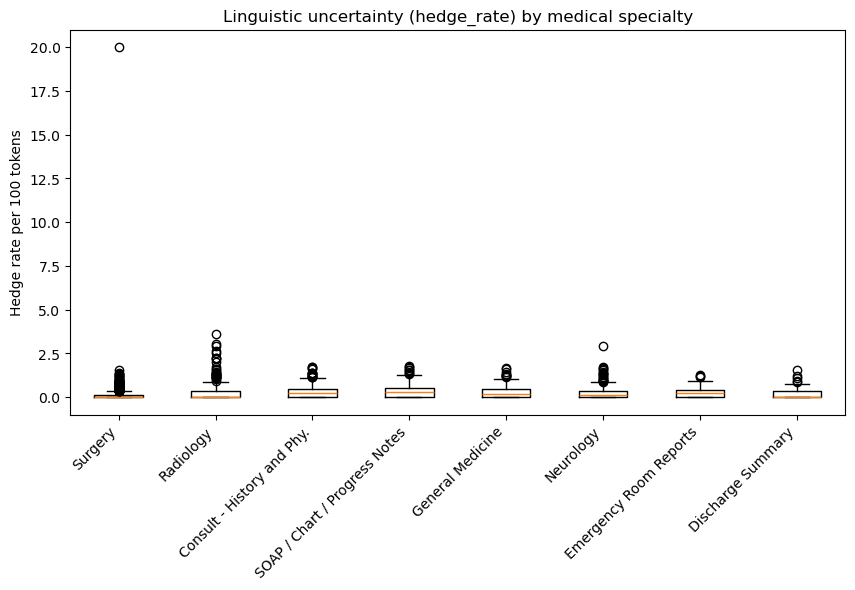

In [147]:
#Boxplot: hedge_rate by specialty
plt.figure(figsize=(10, 5))

data = [
    df_sub[df_sub["medical_specialty"] == s]["hedge_rate"].dropna()
    for s in selected_specialties
]

plt.boxplot(data, labels=selected_specialties)
plt.ylabel("Hedge rate per 100 tokens")
plt.title("Linguistic uncertainty (hedge_rate) by medical specialty")
plt.xticks(rotation=45, ha="right")
plt.show()


C:\Users\lolak\AppData\Local\Temp\ipykernel_23744\732116280.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=selected_specialties)


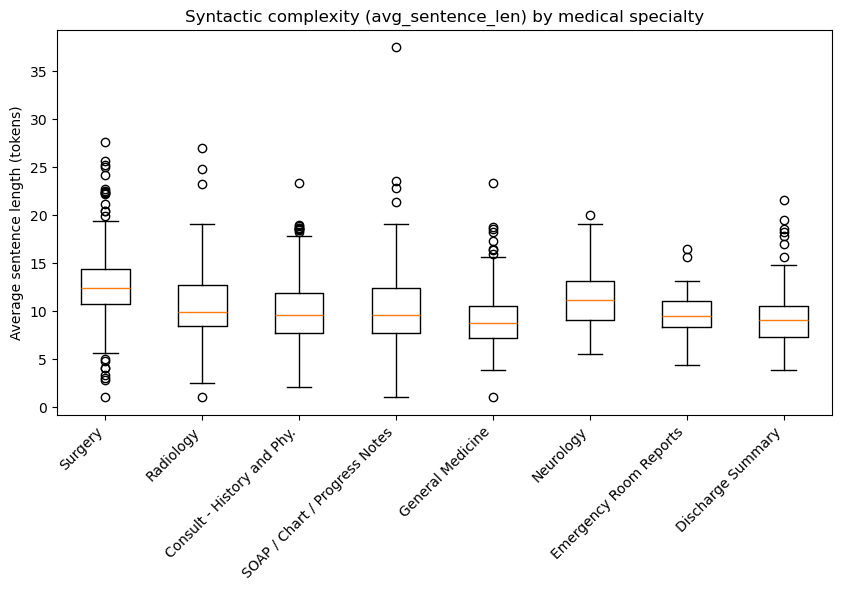

In [148]:
#Boxplot: avg_sentence_len by specialty
plt.figure(figsize=(10, 5))

data = [
    df_sub[df_sub["medical_specialty"] == s]["avg_sentence_len"].dropna()
    for s in selected_specialties
]

plt.boxplot(data, labels=selected_specialties)
plt.ylabel("Average sentence length (tokens)")
plt.title("Syntactic complexity (avg_sentence_len) by medical specialty")
plt.xticks(rotation=45, ha="right")
plt.show()


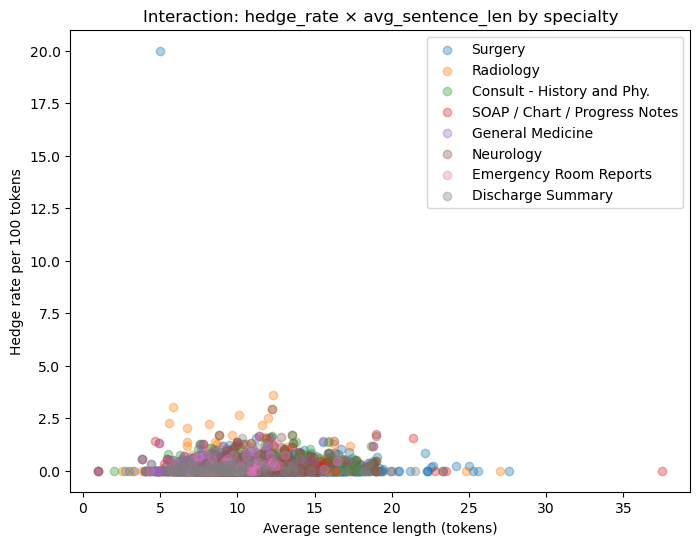

In [149]:
#Interaction plot (Scatter): hedge_rate × avg_sentence_len (colored by specialty)
plt.figure(figsize=(8, 6))

for s in selected_specialties:
    sub = df_sub[df_sub["medical_specialty"] == s]
    plt.scatter(sub["avg_sentence_len"], sub["hedge_rate"], label=s, alpha=0.35)

plt.xlabel("Average sentence length (tokens)")
plt.ylabel("Hedge rate per 100 tokens")
plt.title("Interaction: hedge_rate × avg_sentence_len by specialty")
plt.legend()
plt.show()



In [150]:
# save outputs
df_sub.to_csv("mtsamples_features_selected_specialties.csv", index=False)
summary.to_csv("mtsamples_summary_selected_specialties.csv")

print("Saved:")
print(" - mtsamples_features_selected_specialties.csv")
print(" - mtsamples_summary_selected_specialties.csv")


Saved:
 - mtsamples_features_selected_specialties.csv
 - mtsamples_summary_selected_specialties.csv


In [151]:
df_sub.shape


(2708, 5)

## 7. Statistical analysis

I test:
1) Differences across documentation types (ANOVA)
2) Whether the sentence-length → hedging relationship varies by type (interaction regression)


In [159]:
#חד־כיוונית ANOVA Hedge rate ~ specialty
!pip install statsmodels

import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_hedge = sm.stats.anova_lm(ols("hedge_rate ~ C(medical_specialty)", data=df_sub).fit(), typ=2)
anova_hedge

,sum_sq,df,F,PR(>F)
C(medical_specialty),17.243507,7.0,9.471367,1.160885e-11
Residual,702.228805,2700.0,NaN,NaN


In [160]:
#תוצאה של אנובה:
#C(medical_specialty)
#F = 9.47
#p = 1.16e-11
#specialtiesבין ה hedge_rateז.א., יש הבדלים מובהקים מאוד ב־
 
#(p < 10⁻¹⁰)הסיכוי שההבדלים שראית נוצרו במקרה הוא זעיר


In [161]:
# גודל אפקט(η²):
eta_sq_hedge = (
    anova_hedge.loc["C(medical_specialty)", "sum_sq"] /
    (anova_hedge.loc["C(medical_specialty)", "sum_sq"] + anova_hedge.loc["Residual", "sum_sq"])
)
eta_sq_hedge

#η² ≈ 0.024 (≈ 2.4%)
#אפקט קטן–בינוני
#N≈2500מאוד סביר בדאטה לשוני טבעי וכשמדובר ב־

np.float64(0.023966880531241113)

In [162]:
#ANOVA: avg_sentence_len ~ medical_specialty
anova_len = sm.stats.anova_lm(ols("avg_sentence_len ~ C(medical_specialty)", data=df_sub).fit(), typ=2)
anova_len


,sum_sq,df,F,PR(>F)
C(medical_specialty),4870.869689,7.0,70.99514,1.713042e-94
Residual,26463.276472,2700.0,NaN,NaN


In [163]:
eta_sq_len = (
    anova_len.loc["C(medical_specialty)", "sum_sq"] /
    (anova_len.loc["C(medical_specialty)", "sum_sq"] + anova_len.loc["Residual", "sum_sq"])
)

eta_sq_len


np.float64(0.15544925539268672)

In [164]:
#ANOVA: avg_sentence_len ~ medical_specialty
#F(7, 2700) = 70.99
#p = 1.7 × 10⁻⁹⁴ 
#η² ≈ 0.155 → 15.5% 

In [168]:
# ממודל רגרסיה לינארית
model_inter = ols("hedge_rate ~ avg_sentence_len * C(medical_specialty)", data=df_sub).fit()
print(model_inter.summary())


                            OLS Regression Results                            
Dep. Variable:             hedge_rate   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.195
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           9.11e-16
Time:                        12:35:27   Log-Likelihood:                -1994.6
No. Observations:                2708   AIC:                             4021.
Df Residuals:                    2692   BIC:                             4116.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

## 8. Conclusions (takeaway)

- Documentation type strongly shapes sentence structure (large effect on avg sentence length).
- Hedge rates differ across documentation types, but with a smaller effect size.
- Crucially, the relationship between sentence length and hedging is **not uniform**:
  - In some genres (e.g., Surgery, Radiology), longer sentences do **not** indicate higher uncertainty.
  
**Implication:** simple linguistic features require **genre-aware interpretation** in clinical NLP / HealthTech settings.


In [169]:
import os
os.makedirs("../results", exist_ok=True)

summary.to_csv("../results/mtsamples_summary.csv")
df_sub.to_csv("../results/mtsamples_features.csv", index=False)
print("Saved results to ../results/")


Saved results to ../results/
